In [187]:
#Tratamieto de datos
import pandas as pd 
import numpy as np  
# ==============================================================================================================================================================

#   Gráficos 
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
# ==============================================================================================================================================================

#Procesado y Modelado
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, accuracy_score)
from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve

#REGRESIÓN LOGÍSTICA MULTICLASS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold



import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor
# ==============================================================================================================================================================

# Configuración matplotlib
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')
# Configuración warnings
# ==============================================================================================================================================================

#Configuración warnings
import warnings
warnings.filterwarnings('ignore')

In [188]:
data=pd.read_excel(r"D:\Never Urueta\2023\Algoritmos Tesis\Data.xlsx") 

In [189]:
data1 = data1 = data.drop(["PBA", "CF", "Indicador", "DESTINO", "CAPACIDAD DEL CUARTO FRIO  "], axis=1)

In [190]:
data1["Rechazados_Multiclass"] = data1["Rechazados"] 
data1.loc[data1["Rechazados_Multiclass"] > 1, "Rechazados_Multiclass"] = 2
print(data1.Rechazados_Multiclass.value_counts().sort_index())

0    1329
1     222
2     363
Name: Rechazados_Multiclass, dtype: int64


In [191]:
###VARIABLES CATEGORICAS Y NUMERICAS
features = list(set(data1.columns.values) - set(['ID', 'TARGET']))
cat_features = [feat for feat in features if data1[feat].dtype.name in ['category', 'object']]
num_features = list(set(features) - set(cat_features))

print(f"Factores Categoricos: \n {cat_features}")
print(f"Factores Numéricos: \n {num_features}")

Factores Categoricos: 
 ['Franja1', 'Franja2', 'Dia_Semana', 'pH_Requisito', 'TIPO_CAP_CF', 'Refrigeracion']
Factores Numéricos: 
 ['Rechazados_Multiclass', 'VT2', 'PPPCF', 'Temp2', 'Ocupacion', 'Ti2', 'Tamin', 'VT1', 'Temp3', 'Taamax', 'Rechazados', 'Canales', 'Temp1', 'Ti1']


In [192]:
data1.isnull().sum() #Datos faltantes

Dia_Semana                0
Temp1                     0
Franja1                   0
Temp2                     0
Franja2                   0
VT1                       0
Ti1                       0
Temp3                     0
Ti2                       0
VT2                       0
Refrigeracion             0
Canales                   0
PPPCF                     0
Ocupacion                 0
pH_Requisito              0
Tamin                    29
Taamax                   29
TIPO_CAP_CF               0
Rechazados                0
Rechazados_Multiclass     0
dtype: int64

In [193]:
data1['Tamin'].fillna(data1['Tamin'].median(), inplace=True)
print("valores perdidos en Tamin: " + 
      str(data1['Tamin'].isnull().sum()))
data1['Taamax'].fillna(data1['Taamax'].median(), inplace=True)
print("valores perdidos en Taamax: " + 
      str(data1['Taamax'].isnull().sum()))

valores perdidos en Tamin: 0
valores perdidos en Taamax: 0


In [194]:
data1.describe()

,Temp1,Temp2,VT1,Ti1,Temp3,Ti2,VT2,Canales,PPPCF,Ocupacion,Tamin,Taamax,Rechazados,Rechazados_Multiclass
count,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000
mean,3.080371,11.733454,8.653083,2.129855,2.766437,33.368273,-8.955836,136.827586,22.518286,93.083697,23.857913,32.530543,0.552247,0.495298
std,1.614204,3.365969,3.251896,1.135182,1.774718,14.483894,3.597810,30.208935,15.420267,11.038884,0.960839,1.664524,0.930765,0.793484
min,-4.700000,1.400000,-3.200000,0.166667,-5.600000,24.000000,-35.200000,27.000000,3.991370,19.354839,20.400000,27.200000,0.000000,0.000000
25%,2.100000,10.000000,6.800000,1.583333,2.000000,24.250000,-10.900000,140.000000,17.022934,91.888046,23.300000,31.600000,0.000000,0.000000
50%,2.900000,11.500000,8.500000,1.883333,3.000000,25.250000,-9.000000,150.000000,19.326683,96.774194,24.000000,32.600000,0.000000,0.000000
75%,3.900000,13.800000,10.500000,2.483333,3.800000,37.757500,-7.000000,155.000000,23.219814,100.000000,24.500000,33.600000,1.000000,1.000000
max,18.200000,39.400000,36.800000,16.183333,7.300000,110.200000,4.200000,239.000000,100.000000,104.761905,26.000000,36.300000,5.000000,2.000000


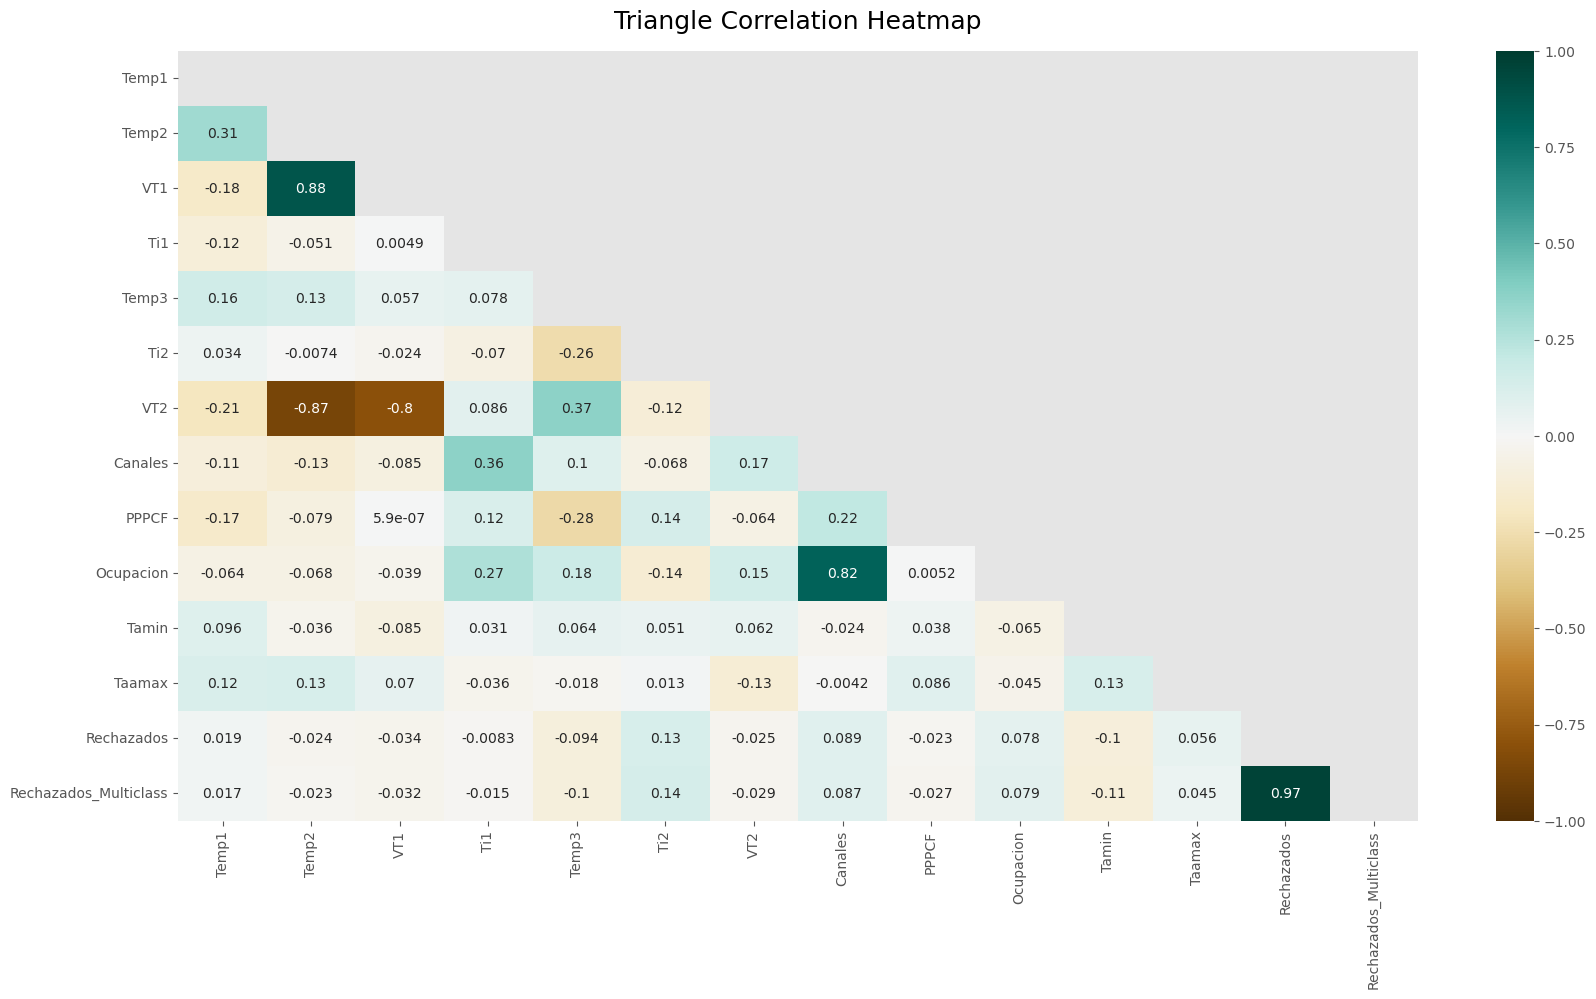

In [195]:
plt.figure(figsize=(20,10))
mask = np.triu(np.ones_like(data1.corr(), dtype=np.bool))
heatmap = sns.heatmap(data1.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);
plt.show()

In [196]:
data1 = data1.drop(["VT1", "VT2", "Rechazados", "Canales"], axis=1)

In [197]:
data1 = pd.get_dummies(data1, drop_first = True, columns = ["Franja1", "Franja2", "Dia_Semana"]) # el parámetro drop first la primera categoría, para evitar problemas de multicolinealidad
data1 = pd.get_dummies(data1, columns = ["Refrigeracion", "pH_Requisito", "TIPO_CAP_CF"]) 

In [198]:
data1.columns

Index(['Temp1', 'Temp2', 'Ti1', 'Temp3', 'Ti2', 'PPPCF', 'Ocupacion', 'Tamin',
       'Taamax', 'Rechazados_Multiclass', 'Franja1_MAÑANA',
       'Franja1_MEDIO_DIA', 'Franja1_NOCHE', 'Franja1_TARDE', 'Franja2_MAÑANA',
       'Franja2_MEDIO_DIA', 'Franja2_NOCHE', 'Franja2_TARDE',
       'Dia_Semana_lunes', 'Dia_Semana_martes', 'Dia_Semana_miércoles',
       'Dia_Semana_sábado', 'Dia_Semana_viernes', 'Refrigeracion_AMONIACO',
       'Refrigeracion_GLICOL', 'pH_Requisito_Mi_5.8', 'pH_Requisito_Mi_6',
       'TIPO_CAP_CF_C1', 'TIPO_CAP_CF_C2', 'TIPO_CAP_CF_C3',
       'TIPO_CAP_CF_PBA2'],
      dtype='object')

In [199]:
#Multicolinealidad - VIFs
pd.Series([variance_inflation_factor(data1.drop(["Rechazados_Multiclass"], axis=1), i) 
               for i in range(data1.drop(["Rechazados_Multiclass"], axis=1).shape[1])], 
              index=data1.drop(["Rechazados_Multiclass"], axis=1).columns)   

Temp1                      1.259138
Temp2                      1.285794
Ti1                        1.505831
Temp3                      1.286710
Ti2                        1.310146
PPPCF                      4.670672
Ocupacion                  1.843314
Tamin                      1.069315
Taamax                     1.090818
Franja1_MAÑANA            61.402552
Franja1_MEDIO_DIA         43.562592
Franja1_NOCHE             31.775524
Franja1_TARDE             69.290192
Franja2_MAÑANA             9.951593
Franja2_MEDIO_DIA         16.074786
Franja2_NOCHE             14.950315
Franja2_TARDE             20.890377
Dia_Semana_lunes           1.698144
Dia_Semana_martes          1.711234
Dia_Semana_miércoles       1.716613
Dia_Semana_sábado          1.794395
Dia_Semana_viernes         1.754715
Refrigeracion_AMONIACO          inf
Refrigeracion_GLICOL            inf
pH_Requisito_Mi_5.8             inf
pH_Requisito_Mi_6               inf
TIPO_CAP_CF_C1                  inf
TIPO_CAP_CF_C2              

In [200]:
#Multicolinealidad - VIFs
pd.Series([variance_inflation_factor(data1.drop(["Rechazados_Multiclass"], axis=1), i) 
               for i in range(data1.drop(["Rechazados_Multiclass"], axis=1).shape[1])], 
              index=data1.drop(["Rechazados_Multiclass"], axis=1).columns)   

Temp1                      1.259138
Temp2                      1.285794
Ti1                        1.505831
Temp3                      1.286710
Ti2                        1.310146
PPPCF                      4.670672
Ocupacion                  1.843314
Tamin                      1.069315
Taamax                     1.090818
Franja1_MAÑANA            61.402552
Franja1_MEDIO_DIA         43.562592
Franja1_NOCHE             31.775524
Franja1_TARDE             69.290192
Franja2_MAÑANA             9.951593
Franja2_MEDIO_DIA         16.074786
Franja2_NOCHE             14.950315
Franja2_TARDE             20.890377
Dia_Semana_lunes           1.698144
Dia_Semana_martes          1.711234
Dia_Semana_miércoles       1.716613
Dia_Semana_sábado          1.794395
Dia_Semana_viernes         1.754715
Refrigeracion_AMONIACO          inf
Refrigeracion_GLICOL            inf
pH_Requisito_Mi_5.8             inf
pH_Requisito_Mi_6               inf
TIPO_CAP_CF_C1                  inf
TIPO_CAP_CF_C2              

In [201]:
data1 = data1.drop(["Temp2"], axis=1)

In [202]:
data1 = data1.drop(["Tamin"], axis=1)

In [203]:
data1 = data1.drop(["Ocupacion"], axis=1)

In [204]:
data1 = data1.drop(["Taamax", "Franja2_TARDE","TIPO_CAP_CF_C3"], axis=1)

In [205]:
data1 = data1.drop(["Refrigeracion_GLICOL", "pH_Requisito_Mi_6","TIPO_CAP_CF_PBA2"], axis=1)


In [206]:
#Eliminando la Multicolinealidad
data1 = data1.drop(["Franja1_MAÑANA", "Franja1_MEDIO_DIA","Franja1_NOCHE", "Franja1_TARDE"], axis=1)

# Seguir con lo Multiclass - EL MODELO

In [207]:
X = data1.drop(["Rechazados_Multiclass"], axis=1)
Y = data1["Rechazados_Multiclass"]

In [208]:
from sklearn import linear_model
lm = linear_model.LogisticRegression(multi_class="multinomial", solver='lbfgs')
lm.fit(X, Y)

LogisticRegression(multi_class='multinomial')

In [209]:
"""Sign = pd.DataFrame(np.zeros((17,2)), columns=["Variable", "P-value"])
from scipy.stats import pearsonr
b=0
for i in X.drop(["const"], axis=1):
    corr_test = pearsonr(X.loc[:,i], Y)
    Sign.loc[b,"Variable"] = i
    Sign.loc[b,'P-value'] = np.round(corr_test[1],3)
    b=b+1

Sign.sort_values("P-value")"""


'Sign = pd.DataFrame(np.zeros((17,2)), columns=["Variable", "P-value"])\nfrom scipy.stats import pearsonr\nb=0\nfor i in X.drop(["const"], axis=1):\n    corr_test = pearsonr(X.loc[:,i], Y)\n    Sign.loc[b,"Variable"] = i\n    Sign.loc[b,\'P-value\'] = np.round(corr_test[1],3)\n    b=b+1\n\nSign.sort_values("P-value")'

In [210]:
X = sm.add_constant(X)
model=sm.MNLogit(Y,X)
result=model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.770225
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                            MNLogit Regression Results                           
=================================================================================
Dep. Variable:     Rechazados_Multiclass   No. Observations:                 1914
Model:                           MNLogit   Df Residuals:                     1878
Method:                              MLE   Df Model:                           34
Date:                   Thu, 15 Jun 2023   Pseudo R-squ.:                 0.05893
Time:                           12:10:01   Log-Likelihood:                -1474.2
converged:                          True   LL-Null:                       -1566.5
Covariance Type:               nonrobust   LLR p-value:                 1.292e-22
===========================================================================================
Rechazados_Multiclass=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -1.4156      0.490     -2.891      0.004      -2.375      -0.456
Temp1                      -0.1570      0.059     -2.670      0.008      -0.272      -0.042
Ti1                         0.0783      0.060      1.300      0.193      -0.040       0.196
Temp3                      -0.1117      0.044     -2.551      0.011      -0.198      -0.026
Ti2                         0.0233      0.005      4.284      0.000       0.013       0.034
PPPCF                      -0.0337      0.010     -3.515      0.000      -0.053      -0.015
Franja2_MAÑANA             -0.3897      0.280     -1.391      0.164      -0.939       0.159
Franja2_MEDIO_DIA          -0.4660      0.227     -2.051      0.040      -0.911      -0.021
Franja2_NOCHE              -0.3691      0.183     -2.015      0.044      -0.728      -0.010
Dia_Semana_lunes            0.3307      0.257      1.285      0.199      -0.174       0.835
Dia_Semana_martes           0.2443      0.254      0.963      0.336      -0.253       0.742
Dia_Semana_miércoles        0.2428      0.251      0.968      0.333      -0.249       0.734
Dia_Semana_sábado          -0.3238      0.271     -1.193      0.233      -0.856       0.208
Dia_Semana_viernes         -0.3471      0.274     -1.269      0.205      -0.883       0.189
Refrigeracion_AMONIACO      0.1321      0.181      0.729      0.466      -0.223       0.487
pH_Requisito_Mi_5.8         0.3676      0.181      2.028      0.043       0.012       0.723
TIPO_CAP_CF_C1             -0.1972      0.298     -0.661      0.508      -0.782       0.387
TIPO_CAP_CF_C2              0.0080      0.325      0.025      0.980      -0.629       0.645
-------------------------------------------------------------------------------------------
Rechazados_Multiclass=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -1.5241      0.409     -3.728      0.000      -2.325      -0.723
Temp1                       0.0403      0.039      1.045      0.296      -0.035       0.116
Ti1                        -0.1715      0.076     -2.257      0.024      -0.321      -0.023
Temp3                      -0.1422      0.036     -3.901      0.000      -0.214      -0.071
Ti2                         0.0277      0.004      6.187      0.000       0.019       0.036
PPPCF                      -0.0153      0.006     -2.666      0.008      -0.026      -0.004
Franja2_MAÑANA             -0.4401      0.233     -1.890      0.059      -0.896       0.016
Franja2_MEDIO_DIA          -0.1677      0.171     -0.983      0.326      -0.502       0.167
Franja2_NOCHE              -0.4067      0.159     -2.553      0.011      -0.719      -0.094
Dia_Semana_lunes            0.1686      0.220      0.766      0.443      -0.262       0.600
Dia_Semana_martes           0.3395      0.207      1.641      0.101      -0.066       

In [211]:
X=X.drop(["Franja2_MAÑANA", "Dia_Semana_lunes", "Dia_Semana_martes", "Dia_Semana_miércoles", "Dia_Semana_sábado", "Refrigeracion_AMONIACO"], axis=1)

In [212]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size= 0.4, random_state = 1)

In [213]:
from sklearn import linear_model
lm = linear_model.LogisticRegression(multi_class="multinomial", solver='lbfgs')
lm.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

In [214]:
lm.score(X_test, y_test)

0.7075718015665796

array([[539,   0,   3],
       [ 77,   1,   1],
       [142,   1,   2]], dtype=int64)

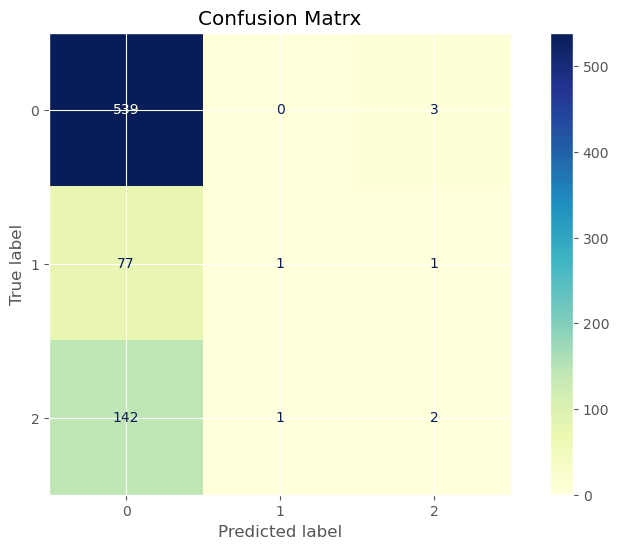

In [215]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx')

disp =metrics.plot_confusion_matrix(lm, X_test, y_test, ax = ax, cmap="YlGnBu")
disp.confusion_matrix

In [216]:
print(metrics.classification_report(y_test, lm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.71      0.99      0.83       542
           1       0.50      0.01      0.02        79
           2       0.33      0.01      0.03       145

    accuracy                           0.71       766
   macro avg       0.51      0.34      0.29       766
weighted avg       0.62      0.71      0.59       766



In [217]:
print("Interceptos", lm.intercept_)

summary = pd.DataFrame(zip(X.columns, np.transpose(lm.coef_.tolist()[0])), 
                       columns=['Variables', 'coef'])
print(summary)

Interceptos [ 0.41079257 -0.1168455  -0.29394707]
              Variables      coef
0                 const  0.402268
1                 Temp1  0.018640
2                   Ti1 -0.023009
3                 Temp3  0.076204
4                   Ti2 -0.012399
5                 PPPCF  0.020096
6     Franja2_MEDIO_DIA  0.210893
7         Franja2_NOCHE  0.283315
8    Dia_Semana_viernes  0.136422
9   pH_Requisito_Mi_5.8 -0.293858
10       TIPO_CAP_CF_C1  0.553954
11       TIPO_CAP_CF_C2  0.208279


El modelo logra clasificar correctamente el 71% de las observaciones, el umbral esperado es del 69,4%; po lo tanto; es un modelo adecuedo de clasificación. 